In [ ]:
##
## Marketing Campaigns Efficacy
##

In [44]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from google.colab import drive
drive.mount('/content/drive')



## STEP 1: Data Understanding

## If you are using JupyterNotebook .. Uncomment the lines below and comment the Google Drive Path
# If Jupyter Notebook
# df = pd.read_csv("data/bank.csv", sep=';')

!ls "/content/drive/MyDrive/Colab Notebooks/data/MarketingCampaigns/"
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/MarketingCampaigns/bank.csv", sep=';')
y = df["y"].map({"no": 0, "yes": 1})

df_full = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/MarketingCampaigns/bank-full.csv", sep=';')
y = df_full["y"].map({"no": 0, "yes": 1})

print(df.info())
print(df['y'].value_counts(normalize=True))

print(df.dtypes.sort_index())

# Missing values (count and %)
miss_ct = df.isna().sum()
miss_pct = (miss_ct / len(df) * 100).round(2)
missing = pd.DataFrame({"missing_count": miss_ct, "missing_%": miss_pct})
print("\nMissing values by column:")
print(missing[missing["missing_count"] > 0].sort_values("missing_count", ascending=False)
if missing["missing_count"].sum() > 0
else "No missing values detected.")

target_col = "y"
if target_col in df.columns:
  print(f"\nTarget (‘{target_col}’) distribution:")
  print(df[target_col].value_counts(dropna=False))
  print("\nTarget (‘{0}’) distribution (proportion):".format(target_col))
  print(df[target_col].value_counts(normalize=True, dropna=False).round(4))


print(df_full.info())
print(df_full['y'].value_counts(normalize=True))

print(df_full.dtypes.sort_index())

# Missing values (count and %)
miss_ct = df_full.isna().sum()
miss_pct = (miss_ct / len(df_full) * 100).round(2)
missing = pd.DataFrame({"missing_count": miss_ct, "missing_%": miss_pct})
print("\nMissing values by column:")
print(missing[missing["missing_count"] > 0].sort_values("missing_count", ascending=False)
if missing["missing_count"].sum() > 0
else "No missing values detected.")

target_col = "y"
if target_col in df_full.columns:
  print(f"\nTarget (‘{target_col}’) distribution:")
  print(df_full[target_col].value_counts(dropna=False))
  print("\nTarget (‘{0}’) distribution (proportion):".format(target_col))
  print(df[target_col].value_counts(normalize=True, dropna=False).round(4))




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
bank.csv  bank-full.csv  bank-names.txt
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 n

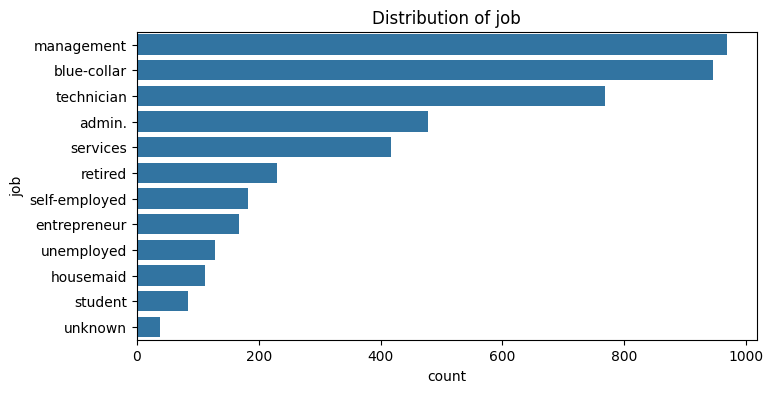

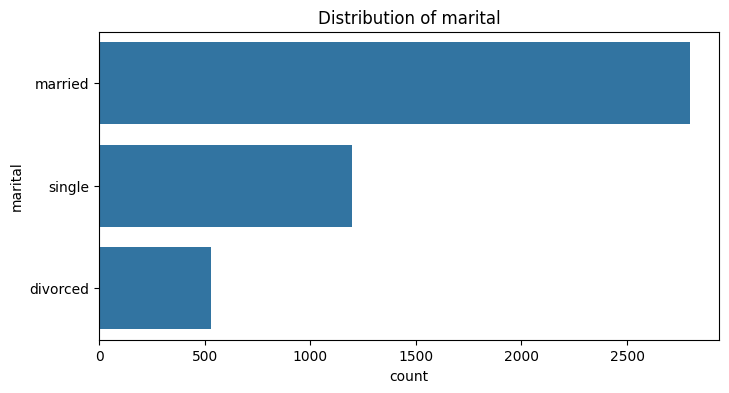

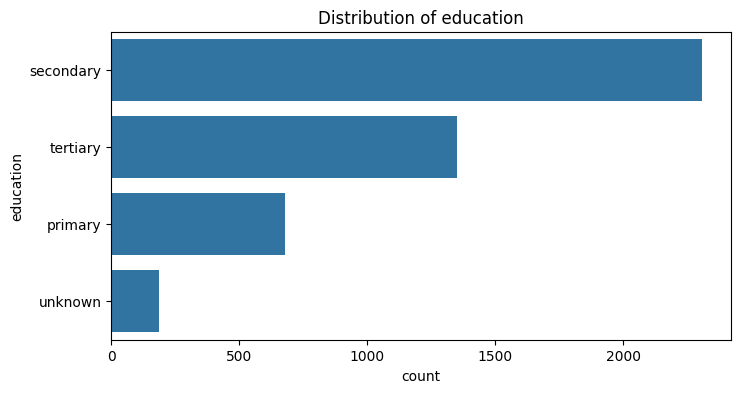

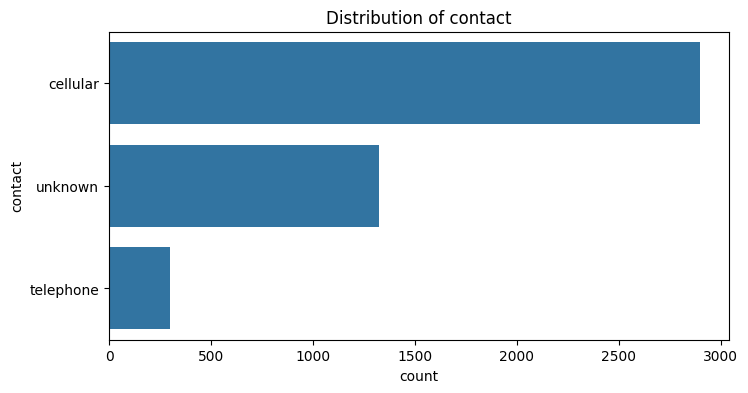

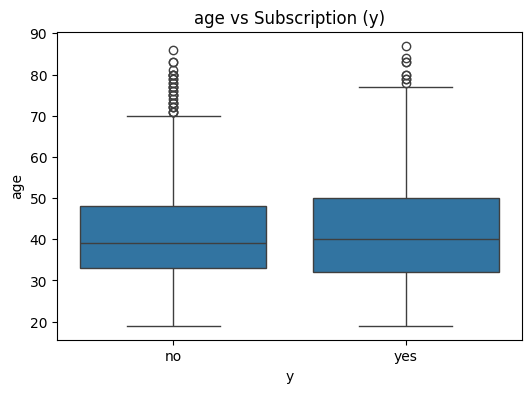

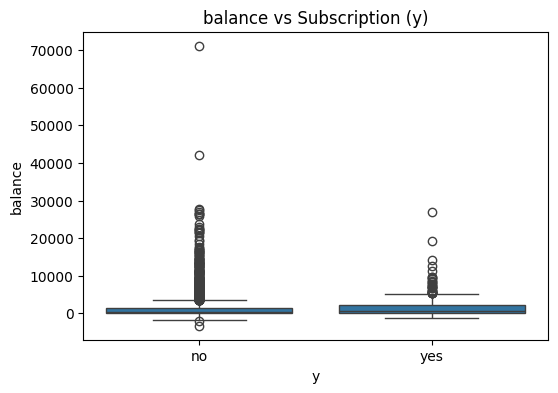

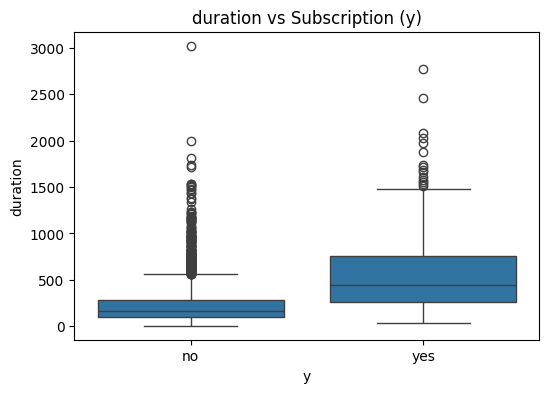

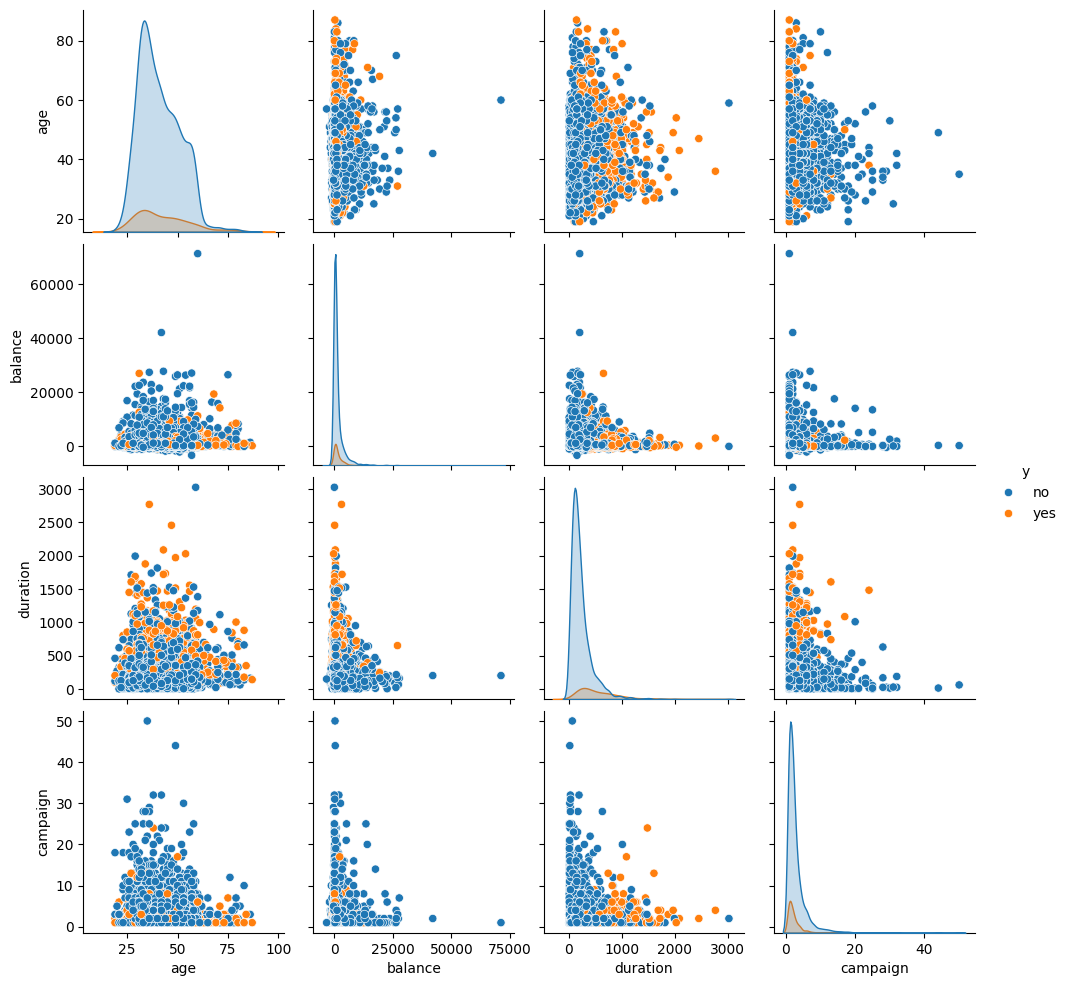

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

#Understand which job, marital, or education groups dominate the dataset.
cat_cols = ['job', 'marital', 'education', 'contact']
for c in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(y=c, data=df, order=df[c].value_counts().index)
    plt.title(f'Distribution of {c}')
    plt.show()

for c in ['age', 'balance', 'duration']:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='y', y=c, data=df)
    plt.title(f'{c} vs Subscription (y)')
    plt.show()

sns.pairplot(df[['age','balance','duration','campaign','y']], hue='y')
plt.show()

In [46]:
## Observation 1: From the above value counts ... it is evident that only 11.52% of the data is 'y' (Class Imbalance is common)
## Observation 2: Missing values by column: No missing values detected.
## Observation 3: Target (‘y’) distribution (proportion): is same with the small and the full data samples.


In [47]:
## Step 2: Data preparation

In [48]:
# Identify numeric vs object (categorical) columns
num_cols = df.select_dtypes(exclude="object").columns.tolist()
cat_cols = df.select_dtypes(include="object").columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# Separate features and target
X = df.drop("y", axis=1)
y = df["y"]

# Identify categorical vs numeric columns
cat_cols = X.select_dtypes(include="object").columns
num_cols = X.select_dtypes(exclude="object").columns

cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(exclude="object").columns.tolist()

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", ohe, cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop",
)

print("ColumnTransformer created successfully!")

from sklearn.model_selection import train_test_split

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


Numeric columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
ColumnTransformer created successfully!


In [54]:
## Modeling

# ============================
# Bank Marketing: 4-Classifiers Compare
# (KNN, Logistic Regression, Decision Tree, SVM)
# ============================

import numpy as np

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


# ---------
# Pipelines
# ---------
pipe_knn = Pipeline([
    ("pre", preprocessor),
    ("model", KNeighborsClassifier())
])

pipe_lr = Pipeline([
    ("pre", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

pipe_dt = Pipeline([
    ("pre", preprocessor),
    ("model", DecisionTreeClassifier(random_state=42, class_weight="balanced"))
])

pipe_svm = Pipeline([
    ("pre", preprocessor),
    ("model", SVC(probability=True, class_weight="balanced", random_state=42))
])

# -----------------------
# Hyperparameter grids
# -----------------------
param_grids = {
    "KNN": {
        "model__n_neighbors": [5, 11, 21],
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2],  # Manhattan vs Euclidean
    },
    "LogReg": {
        "model__C": [0.1, 1, 3, 10],
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs"],  # good default for OHE + many features
    },
    "DecisionTree": {
        "model__max_depth": [None, 6, 10, 16],
        "model__min_samples_split": [2, 10, 30],
        "model__min_samples_leaf": [1, 5, 10],
    },
    "SVM": {
        "model__C": [0.5, 1, 3],
        "model__kernel": ["rbf"],
        "model__gamma": ["scale", "auto"],
    },
}

models = {
    "KNN": pipe_knn,
    "LogReg": pipe_lr,
    "DecisionTree": pipe_dt,
    "SVM": pipe_svm,
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# -----------------------
# Train/tune/evaluate
# -----------------------
from sklearn.preprocessing import label_binarize

def evaluate_model(name, pipe, grid, X_tr, y_tr, X_te, y_te):
    gs = GridSearchCV(
        pipe,
        grid,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1,
        verbose=0,
        error_score=0.0
    )
    gs.fit(X_tr, y_tr)

    best = gs.best_estimator_

    # figure out which column in predict_proba corresponds to the positive class
    classes_ = best.named_steps["model"].classes_
    if y_te.dtype == "O":                # string labels
        pos_label = "yes"
        pos_idx = int(np.where(classes_ == "yes")[0])
        y_true_bin = label_binarize(y_te, classes=["no", "yes"]).ravel()
    else:                                # numeric labels
        pos_label = 1
        pos_idx = int(np.where(classes_ == 1)[0])
        y_true_bin = y_te

    y_pred  = best.predict(X_te)
    y_proba = best.predict_proba(X_te)[:, pos_idx]

    metrics = {
        "model": name,
        "best_params": gs.best_params_,
        "cv_roc_auc": gs.best_score_,
        "test_accuracy": accuracy_score(y_te, y_pred),
        "test_precision": precision_score(y_te, y_pred, pos_label=pos_label, zero_division=0),
        "test_recall": recall_score(y_te, y_pred, pos_label=pos_label, zero_division=0),
        "test_f1": f1_score(y_te, y_pred, pos_label=pos_label, zero_division=0),
        "test_roc_auc": roc_auc_score(y_true_bin, y_proba),
        "confusion_matrix": confusion_matrix(y_te, y_pred, labels=classes_),
        "clf_report": classification_report(y_te, y_pred, digits=3, labels=classes_),
    }
    return metrics

results = []
for name, pipe in models.items():
    metrics = evaluate_model(name, pipe, param_grids[name], X_train, y_train, X_test, y_test)
    results.append(metrics)

# -----------------------
# Output: per-model details + summary table
# -----------------------
for r in results:
    print("\n" + "="*70)
    print(f"{r['model']} — Best Params: {r['best_params']}")
    print(f"CV ROC-AUC: {r['cv_roc_auc']:.4f}")
    print("Confusion Matrix:\n", r["confusion_matrix"])
    print("Classification Report:\n", r["clf_report"])
    print(f"Test ROC-AUC: {r['test_roc_auc']:.4f}")

summary = pd.DataFrame([{
    "Model": r["model"],
    "CV ROC-AUC": r["cv_roc_auc"],
    "Test ROC-AUC": r["test_roc_auc"],
    "Accuracy": r["test_accuracy"],
    "Precision": r["test_precision"],
    "Recall": r["test_recall"],
    "F1": r["test_f1"],
    "Best Params": r["best_params"],
} for r in results]).sort_values("Test ROC-AUC", ascending=False)

print("\n" + "="*70)
print("Summary (sorted by Test ROC-AUC)")
print(summary.to_string(index=False))


/tmp/ipython-input-2834669283.py:106: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos_idx = int(np.where(classes_ == "yes")[0])
/tmp/ipython-input-2834669283.py:106: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos_idx = int(np.where(classes_ == "yes")[0])
/tmp/ipython-input-2834669283.py:106: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pos_idx = int(np.where(classes_ == "yes")[0])
/tmp/ipython-input-2834669283.py:106: DeprecationWarning: Conversion of an arra


KNN — Best Params: {'model__n_neighbors': 21, 'model__p': 2, 'model__weights': 'distance'}
CV ROC-AUC: 0.8601
Confusion Matrix:
 [[1189   12]
 [ 137   19]]
Classification Report:
               precision    recall  f1-score   support

          no      0.897     0.990     0.941      1201
         yes      0.613     0.122     0.203       156

    accuracy                          0.890      1357
   macro avg      0.755     0.556     0.572      1357
weighted avg      0.864     0.890     0.856      1357

Test ROC-AUC: 0.8349

LogReg — Best Params: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}
CV ROC-AUC: 0.8940
Confusion Matrix:
 [[1019  182]
 [  37  119]]
Classification Report:
               precision    recall  f1-score   support

          no      0.965     0.848     0.903      1201
         yes      0.395     0.763     0.521       156

    accuracy                          0.839      1357
   macro avg      0.680     0.806     0.712      1357
weighted avg      0